#### Библиотеки

In [1]:
print("feeffefe")

feeffefe


In [96]:
import requests
import matplotlib.pyplot as plt
import datetime
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gym
from gym import spaces
from gym.envs.registration import register
import transformers
import torch
import sklearn
import yfinance as yf
import json
import time
import logging
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


#### Данные

In [2]:
symbol = 'INTC'
start_date = '2020-01-01'
end_date = '2023-07-05'

df_long = yf.download(symbol, start=start_date, end=end_date, interval='1d')

df_long = df_long.reset_index()
df_long['open'] = df_long['Open'].astype(float)
df_long['high'] = df_long['High'].astype(float)
df_long['low'] = df_long['Low'].astype(float)
df_long['close'] = df_long['Close'].astype(float)
df_long['adj_close'] = df_long['Adj Close'].astype(float)
df_long['volume'] = df_long['Volume'].astype(int)
df_long['date'] = df_long['Date'].astype(str)

df_long.dtypes

[*********************100%%**********************]  1 of 1 completed


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int32
date                 object
dtype: object

In [3]:
df_pre = df_long[['date','close']]
df_pre.head()

,date,close
0,2020-01-02,60.840000
1,2020-01-03,60.099998
2,2020-01-06,59.930000
3,2020-01-07,58.930000
4,2020-01-08,58.970001


#### Yahoo

In [6]:
import yfinance as yf

symbol = 'INTC'
start_date = '2020-01-01'
end_date = '2023-07-05'

# Получите исторические данные из Yahoo Finance
df_long = yf.download(symbol, start=start_date, end=end_date, interval='1d')

df_long = df_long.reset_index()
df_long['open'] = df_long['Open'].astype(float)
df_long['high'] = df_long['High'].astype(float)
df_long['low'] = df_long['Low'].astype(float)
df_long['close'] = df_long['Close'].astype(float)
df_long['adj_close'] = df_long['Adj Close'].astype(float)
df_long['volume'] = df_long['Volume'].astype(int)
df_long['date'] = df_long['Date'].astype(str)

df_long.dtypes

[*********************100%%**********************]  1 of 1 completed


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int32
date                 object
dtype: object

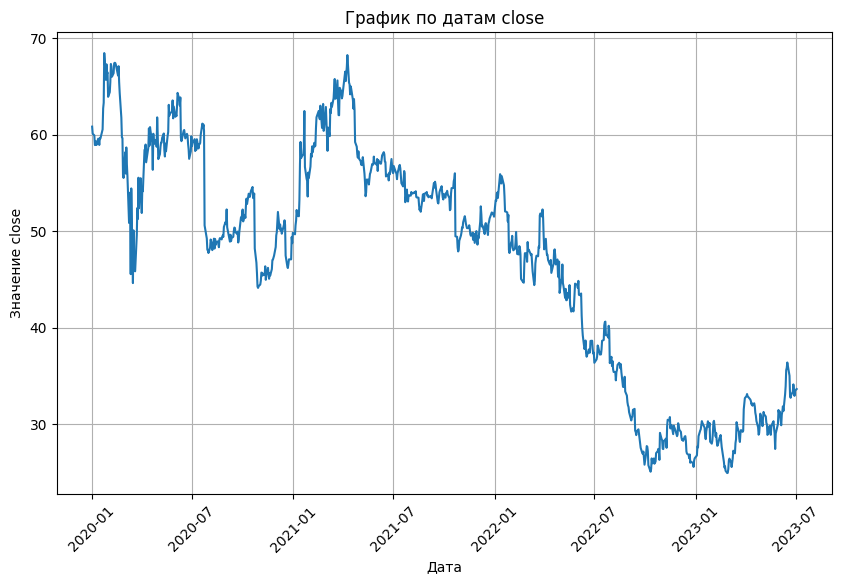

In [7]:
plt.figure(figsize=(10, 6))

# Постройте график
plt.plot(df_long['Date'], df_long['close'])
plt.title('График по датам close')
plt.xlabel('Дата')
plt.ylabel('Значение close')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

#### Препроцессинг

In [8]:
df_pre = df_long[['date','close']]
df_pre

,date,close
0,2020-01-02,60.840000
1,2020-01-03,60.099998
2,2020-01-06,59.930000
3,2020-01-07,58.930000
4,2020-01-08,58.970001
...,...,...
876,2023-06-27,34.099998
877,2023-06-28,33.570000
878,2023-06-29,32.910000
879,2023-06-30,33.439999


In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
datetime_object = str_to_datetime('1986-03-19')
datetime_object

In [ ]:
df_pre['date'] = df_pre['date'].apply(str_to_datetime)

<ipython-input-14-12d869df47f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['date'] = df_pre['date'].apply(str_to_datetime)


In [ ]:
df_pre = df_pre.set_index('date')
df_pre.head()

In [ ]:
def df_to_windowed_df(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['close'].shift(i)
    windowed_data['Target'] = data['close']
    return windowed_data.dropna()

In [ ]:
windowed_df = df_to_windowed_df(df_pre)
windowed_df = windowed_df.reset_index()
windowed_df

,date,Target-3,Target-2,Target-1,Target
0,2020-01-07,60.840000,60.099998,59.930000,58.930000
1,2020-01-08,60.099998,59.930000,58.930000,58.970001
2,2020-01-09,59.930000,58.930000,58.970001,59.299999
3,2020-01-10,58.930000,58.970001,59.299999,58.939999
4,2020-01-13,58.970001,59.299999,58.939999,59.590000
...,...,...,...,...,...
873,2023-06-27,32.709999,33.000000,33.340000,34.099998
874,2023-06-28,33.000000,33.340000,34.099998,33.570000
875,2023-06-29,33.340000,34.099998,33.570000,32.910000
876,2023-06-30,34.099998,33.570000,32.910000,33.439999


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

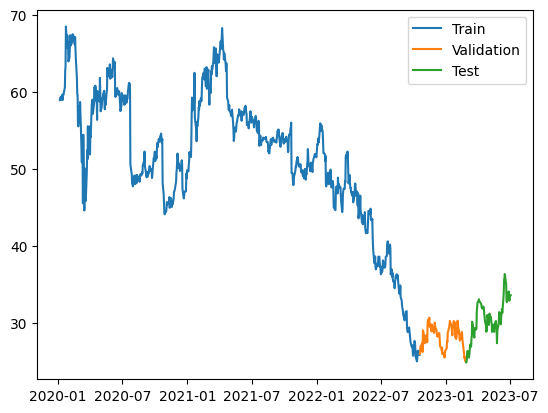

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

#### PRE-TRAINED LSTM

In [ ]:
# !ls /content/torch_model/suryaR-15/data

0  1  10  11  12  13  14  15  16  17  18  19  2  20  21  3  4  5  6  7	8  9


In [ ]:
# !rm -rf /content/torch_model/suryaR-15

##### Конфиг-файлы

In [ ]:
# config_data = """
# {
#   "input_dim": 1,
#   "hidden_dim": 64,
#   "num_layers": 5,
#   "output_dim": 1,
#   "num_epochs": 500
# }
# """

# # Запись данных в файл
# with open("/content/config.json", "w") as file:
#     file.write(config_data)

In [2]:
import torch
import torch.nn as nn

class LSTMStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

##### Загрузка модели

In [3]:
config_path = 'lstm_model/config.json'
model_weights_path = 'lstm_model/pytorch_model.bin'

# Загрузка параметров из config.json
with open(config_path, 'r') as f:
    config = json.load(f)

# Создание экземпляра модели
lstm_model = LSTMStockPredictor(
    input_dim=config['input_dim'],
    hidden_dim=config['hidden_dim'],
    num_layers=config['num_layers'],
    output_dim=config['output_dim']
)

# Загрузка весов модели
lstm_model.load_state_dict(torch.load(model_weights_path))
lstm_model.eval()  # Перевод модели в режим оценки

LSTMStockPredictor(
  (lstm): LSTM(1, 64, num_layers=5, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

##### Загрузка данных

In [58]:

# Функция для получения данных и подготовки их для обучения
def get_and_prepare_data(client, symbol, total_limit=100, batch_size=50):
    all_prices = []
    iterations = total_limit // batch_size

    for i in range(iterations):
        r = client.get_public_trade_history(
            category='linear',#"spot",
            symbol=symbol,
            limit=batch_size,
        )
        data = r['result']['list']
        prices = [float(entry['price']) for entry in data]
        all_prices.extend(prices)

    all_prices = np.array(all_prices).reshape(-1, 1)

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(all_prices)

    return data_scaled, scaler

# Функция для создания последовательностей для входных данных модели
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Загрузка данных
data_scaled, scaler = get_and_prepare_data(cl, "ETHUSDT", total_limit=1000, batch_size=50)

In [59]:
data_scaled

array([[0.01724138],
       [0.01724138],
       [0.        ],
       [0.        ],
       [0.33333333],
       [0.        ],
       [0.33333333],
       [0.33333333],
       [0.        ],
       [0.        ],
       [0.33333333],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.33333333],
       [0.32758621],
       [0.32758621],
       [0.32758621],
       [0.32758621],
       [0.32758621],
       [0.33908046],
       [0.35057471],
       [0.33908046],
       [0.35057471],
       [0.33908046],
       [0.35057471],
       [0.33908046],
       [0.29885057],
       [0.35057471],
       [0.29885057],
       [0.35057471],
       [0.35057471],
       [0.29885057],
       [0.34482759],
       [0.38505747],
       [0.34482759],
       [0.34482759],
       [0.37931034],
       [0.37931034],
       [0.42528736],
       [0.42528736],
       [0.42528736],
       [0.37931034],
       [0.42528736],
       [0.41954023],
       [0.41954023],
       [0.41954023],
       [0.419

##### ДОобучение модели

In [161]:
# from pybit.unified_trading import HTTP
# from pybit import exceptions
# import pprint
# import concurrent.futures
# import time
# 
# cl = HTTP(
#     testnet=True,
#     api_key=key,
#     api_secret=secret,
#     recv_window=60000
# )

In [229]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# 
# # Функция для получения данных и подготовки их для обучения
# def get_and_prepare_data(client, symbol, limit=1000):
#     r = client.get_public_trade_history(
#         category="spot",
#         symbol=symbol,
#         limit=limit,
#     )
#     data = r['result']['list']
#     prices = [float(entry['price']) for entry in data]
#     prices = np.array(prices).reshape(-1, 1)
# 
#     # Нормализация данных
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     data_scaled = scaler.fit_transform(prices)
# 
#     return data_scaled, scaler
# 
# # Функция для создания последовательностей для входных данных модели
# def create_dataset(dataset, look_back=1):
#     X, Y = [], []
#     for i in range(len(dataset) - look_back - 1):
#         a = dataset[i:(i + look_back), 0]
#         X.append(a)
#         Y.append(dataset[i + look_back, 0])
#     return np.array(X), np.array(Y)
# 
# # Загрузка данных
# data_scaled, scaler = get_and_prepare_data(cl, "ETHUSDT", limit=10000)
# 
# # Проверка, что данные загружены корректно
# print("Scaled data:", data_scaled)
# 
# # Создание последовательностей для входных данных модели
# look_back = 10#60  # Количество временных шагов для входной последовательности
# if len(data_scaled) > look_back + 1:
#     X, y = create_dataset(data_scaled, look_back)
#     X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Преобразование для LSTM
# else:
#     print(f"Not enough data to create sequences with look_back={look_back}")
# 
# # Конфигурация модели
# config_path = 'lstm_model/config.json'
# model_weights_path = 'lstm_model/pytorch_model.bin'
# 
# # Загрузка параметров из config.json
# with open(config_path, 'r') as f:
#     config = json.load(f)
# 
# # Обновленная модель с Dropout
# class LSTMStockPredictor(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(LSTMStockPredictor, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
# 
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
#         self.fc = nn.Linear(hidden_dim, output_dim)
# 
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
# 
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out
# 
# # Создание экземпляра модели
# lstm_model = LSTMStockPredictor(
#     input_dim=config['input_dim'],
#     hidden_dim=config['hidden_dim'],
#     num_layers=config['num_layers'],
#     output_dim=config['output_dim']
# )
# 
# # Загрузка весов модели
# lstm_model.load_state_dict(torch.load(model_weights_path))
# lstm_model.train()  # Перевод модели в режим обучения
# 
# # Определение функции потерь и оптимизатора
# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)  # Уменьшение скорости обучения
# 
# # Определение количества эпох для дообучения
# num_epochs = 50
# 
# # Процесс дообучения модели
# if len(data_scaled) > look_back + 1:
#     for epoch in range(num_epochs):
#         for i in range(len(X)):
#             inputs = torch.tensor(X[i:i+1], dtype=torch.float32)
#             labels = torch.tensor(y[i:i+1], dtype=torch.float32)
# 
#             # Forward pass
#             outputs = lstm_model(inputs)
#             loss = criterion(outputs, labels)
# 
#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
# 
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# 
#     # Сохранение дообученной модели
#     torch.save(lstm_model.state_dict(), model_weights_path)
# else:
#     print("Not enough data to proceed with training")

Scaled data: [[0.60344828]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.62931034]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.56034483]
 [0.53448276]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.52586207]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.50862069]
 [1.        ]
 [1.        ]
 [0.45689655]
 [1.        ]
 [1.        ]
 [0.48275862]
 [0.48275862]
 [0.49137931]
 [1.        ]
 [0.45689655]]


C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 0.0354
Epoch [2/50], Loss: 0.0489
Epoch [3/50], Loss: 0.0646
Epoch [4/50], Loss: 0.1066
Epoch [5/50], Loss: 0.0805
Epoch [6/50], Loss: 0.0766
Epoch [7/50], Loss: 0.0753
Epoch [8/50], Loss: 0.0666
Epoch [9/50], Loss: 0.1134
Epoch [10/50], Loss: 0.0900
Epoch [11/50], Loss: 0.0834
Epoch [12/50], Loss: 0.0911
Epoch [13/50], Loss: 0.0575
Epoch [14/50], Loss: 0.1045
Epoch [15/50], Loss: 0.0767
Epoch [16/50], Loss: 0.0796
Epoch [17/50], Loss: 0.0810
Epoch [18/50], Loss: 0.0729
Epoch [19/50], Loss: 0.0978
Epoch [20/50], Loss: 0.0728
Epoch [21/50], Loss: 0.0741
Epoch [22/50], Loss: 0.1053
Epoch [23/50], Loss: 0.1288
Epoch [24/50], Loss: 0.0788
Epoch [25/50], Loss: 0.0813
Epoch [26/50], Loss: 0.0785
Epoch [27/50], Loss: 0.0896
Epoch [28/50], Loss: 0.0725
Epoch [29/50], Loss: 0.1116
Epoch [30/50], Loss: 0.0627
Epoch [31/50], Loss: 0.0660
Epoch [32/50], Loss: 0.0955
Epoch [33/50], Loss: 0.0961
Epoch [34/50], Loss: 0.0807
Epoch [35/50], Loss: 0.0767
Epoch [36/50], Loss: 0.1015
E

In [270]:
len(data_scaled)

60

##### Прогноз

In [19]:
# Прогноз
X_tensor = torch.tensor(X).float()
with torch.no_grad():
    predictions = lstm_model(X_tensor)
    predictions = predictions.numpy()

# Обратное масштабирование значений для получения истинных прогнозов
predictions_rescaled = scaler.inverse_transform(predictions)

In [20]:
df_stockdata = pd.DataFrame({
    'Real': data[-len(predictions_rescaled):].flatten(),
    'Predictions': predictions_rescaled.flatten()
})
df_stockdata['Deviations'] = df_stockdata['Real'] - df_stockdata['Predictions']
df_stockdata.head()

,Real,Predictions,Deviations
0,54.119999,52.585621,1.534378
1,51.880001,54.484596,-2.604595
2,54.349998,54.251961,0.098038
3,54.130001,52.165035,1.964966
4,58.430000,53.721729,4.708271


#### Визуализация рез-ов

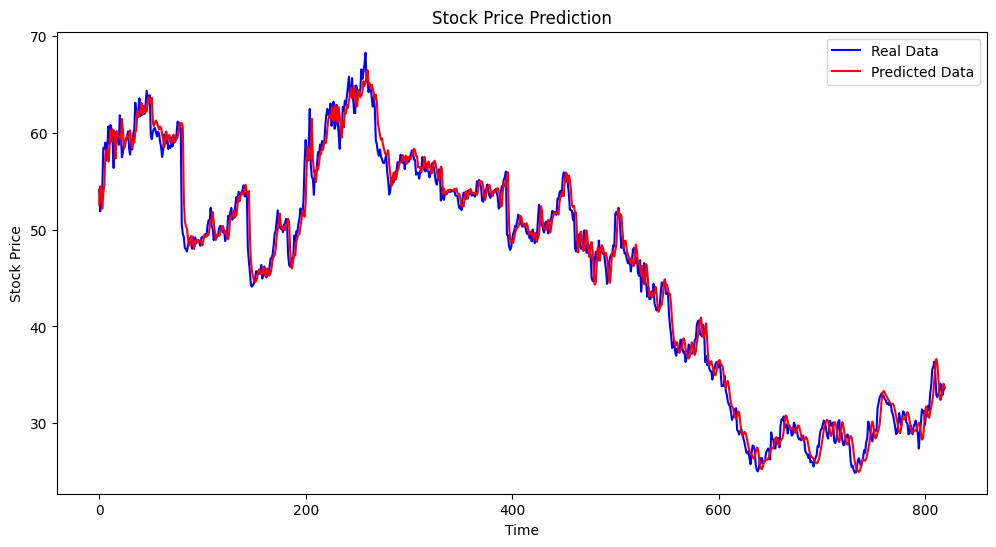

In [ ]:
# Отображение реальных данных и прогнозов на графике
plt.figure(figsize=(12, 6))
plt.plot(data[-len(predictions_rescaled):], label='Real Data', color='blue')  # Реальные данные
plt.plot(predictions_rescaled, label='Predicted Data', color='red')  # Прогнозируемые данные
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

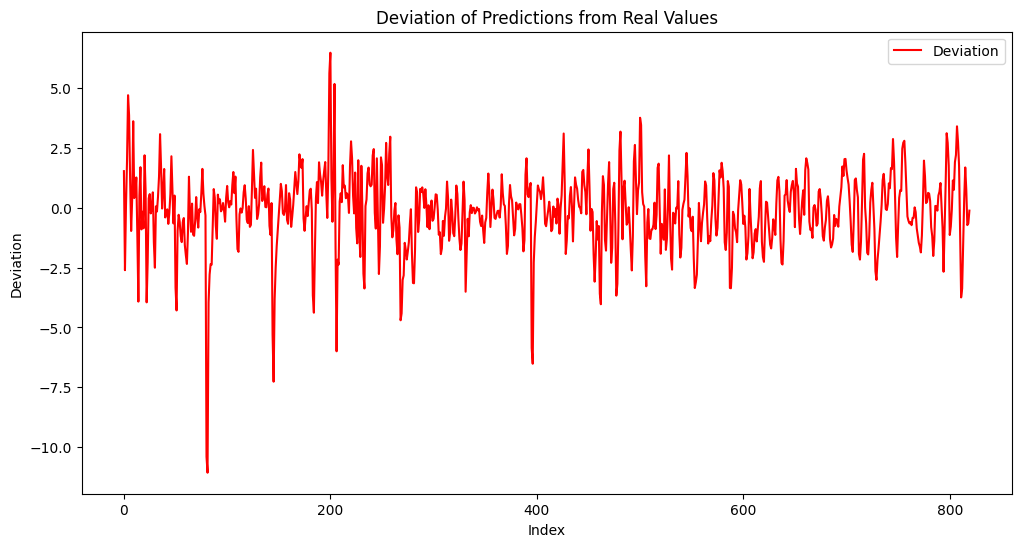

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_stockdata['Deviations'], label='Deviation', color='red')
plt.title('Deviation of Predictions from Real Values')
plt.xlabel('Index')
plt.ylabel('Deviation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

def gini(actual, pred):
    assert len(actual) == len(pred)
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    total_losses = all[:, 0].sum()
    gini_sum = all[:, 0].cumsum().sum() / total_losses
    gini_sum -= (len(actual) + 1) / 2.
    return gini_sum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

gini_score = gini_normalized(df_stockdata['Real'].values, df_stockdata['Predictions'].values)

# Вычисление метрик
mse = mean_squared_error(df_stockdata['Real'], df_stockdata['Predictions'])
mae = mean_absolute_error(df_stockdata['Real'], df_stockdata['Predictions'])
r2 = r2_score(df_stockdata['Real'], df_stockdata['Predictions'])
msle = mean_squared_log_error(df_stockdata['Real'], df_stockdata['Predictions'])

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')
print(f'Normalized Gini Coefficient: {gini_score}')
print(f'Mean Squared Logarithmic Error: {msle}')

MSE: 2.5020799871532957
MAE: 1.1235980243217654
R²: 0.9819544229048033
Normalized Gini Coefficient: 0.9882301047846379
Mean Squared Logarithmic Error: 0.0012164655096395507


Основные статистические показатели:
             Real  Predictions  Deviations
count  820.000000   820.000000  820.000000
mean    46.064085    46.230289   -0.166205
std     11.782303    11.799667    1.574000
min     24.900000    24.978630  -11.070339
25%     33.537499    34.010495   -0.945453
50%     49.179998    49.321712   -0.067842
75%     55.217500    55.470852    0.761596
max     68.260002    66.451729    6.484081

Персентили:
           Real  Predictions  Deviations
0.05  26.969999    27.072523   -2.650751
0.25  33.537499    34.010495   -0.945453
0.50  49.179998    49.321712   -0.067842
0.75  55.217500    55.470852    0.761596
0.95  62.460499    62.327251    2.047715

Мода для 'Real':
26.969999313354492


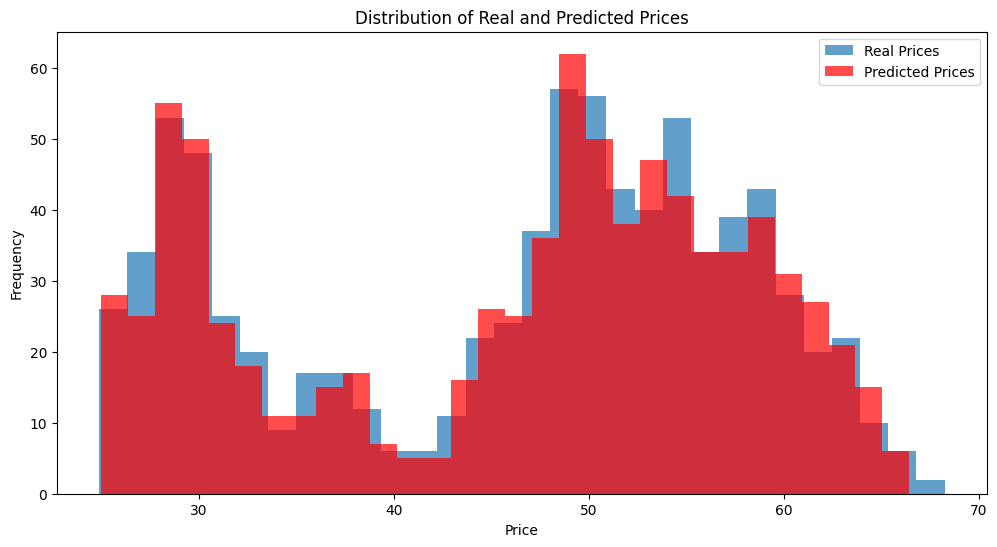

In [ ]:
# Статистический анализ
print("Основные статистические показатели:")
print(df_stockdata.describe())

# Персентили
print("\nПерсентили:")
print(df_stockdata.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# Мода
print("\nМода для 'Real':")
print(df_stockdata['Real'].mode().iloc[0])

plt.figure(figsize=(12, 6))
plt.hist(df_stockdata['Real'], bins=30, alpha=0.7, label='Real Prices')
plt.hist(df_stockdata['Predictions'], bins=30, alpha=0.7, label='Predicted Prices', color='red')
plt.title('Distribution of Real and Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### API песочницы тинька

#### ByBit

##### Libs

In [ ]:
# !pip install pybit

In [ ]:
# !pip install pycrypto

In [ ]:
# !pip install pycryptodome

In [29]:
import requests

# def get_external_ip():
#     response = requests.get('https://api.ipify.org?format=json')
#     if response.status_code == 200:
#         ip = response.json()['ip']
#         return print('fe')#ip
#     else:
#         raise Exception(f"Error fetching IP address: {response.status_code}")
# 
# # Пример использования
# try:
#     external_ip = get_external_ip()
#     print(f"My external IP address is: {external_ip}")
# except Exception as e:
#     print(f"An error occurred: {e}")

fe
My external IP address is: None


In [4]:
import concurrent.futures
from pybit.unified_trading import HTTP
from pybit import exceptions
from collections import deque
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import pprint
import time

##### API

In [10]:
key="///"
secret="///"

In [11]:
cl = HTTP(
    testnet=True,
    api_key=key,
    api_secret=secret,
    recv_window=60000
)

In [12]:
print(cl.upgrade_to_unified_trading_account())

{'retCode': 0, 'retMsg': 'SUCCESS', 'result': {'unifiedUpdateStatus': 'SUCCESS', 'unifiedUpdateMsg': None}, 'retExtInfo': {}, 'time': 1717344357503}


##### Methods

###### get_public_trade_history

In [160]:
r = cl.get_public_trade_history(
    category="spot",
    symbol="ETHUSDT",
    limit=3,
)
print(r)

{'retCode': 0, 'retMsg': 'OK', 'result': {'category': 'spot', 'list': [{'execId': '2110000000036894529', 'symbol': 'ETHUSDT', 'price': '3320.79', 'size': '0.02159', 'side': 'Sell', 'time': '1717334816594', 'isBlockTrade': False}, {'execId': '2110000000036894527', 'symbol': 'ETHUSDT', 'price': '3320.79', 'size': '0.0209', 'side': 'Buy', 'time': '1717334787476', 'isBlockTrade': False}, {'execId': '2110000000036894526', 'symbol': 'ETHUSDT', 'price': '3320.79', 'size': '0.02138', 'side': 'Sell', 'time': '1717334756873', 'isBlockTrade': False}]}, 'retExtInfo': {}, 'time': 1717334825930}


In [58]:
logging.basicConfig(format="%(asctime)s %(message)s", level=logging.DEBUG)
r = cl.get_orderbook(category="linear", symbol="SOLUSDT")
print(r)

2024-05-27 22:34:53,709 https://api-testnet.bybit.com:443 "GET /v5/market/orderbook?category=linear&symbol=SOLUSDT HTTP/1.1" 200 None


{'retCode': 0, 'retMsg': 'OK', 'result': {'s': 'SOLUSDT', 'b': [['170.2', '49150.5'], ['170.18', '41608'], ['170.16', '34476'], ['170.14', '23121'], ['170.12', '51913.3'], ['170.1', '45726.5'], ['170.08', '37842.5'], ['170.07', '0.1'], ['170.06', '47206.3'], ['170.04', '28271.4'], ['170.02', '62436.4'], ['170', '54452.3'], ['169.98', '31075.6'], ['169.95', '0.1'], ['169.94', '55469.9'], ['169.9', '54520.6'], ['169.87', '0.1'], ['169.86', '24715.3'], ['169.82', '42771.6'], ['169.8', '0.1'], ['169.78', '50651.9'], ['169.74', '47622.8'], ['169.72', '0.1'], ['169.7', '25646'], ['169.68', '0.1']], 'a': [['170.22', '44407.8'], ['170.25', '45523.4'], ['170.26', '30159.4'], ['170.29', '55221.5'], ['170.3', '36861.8'], ['170.33', '25859.6'], ['170.34', '52558.7'], ['170.37', '35448.2'], ['170.38', '28298.8'], ['170.41', '4732.6'], ['170.42', '27509.3'], ['170.45', '37132.7'], ['170.46', '23658.2'], ['170.49', '35484.6'], ['170.5', '48597.3'], ['170.53', '41552.1'], ['170.54', '57002.8'], ['170.

In [126]:
pprint.pprint(r.get('result'))

{'a': [['164.3', '36462.5'],
       ['164.33', '54245'],
       ['164.34', '34282.2'],
       ['164.37', '28423.2'],
       ['164.38', '41128.6'],
       ['164.41', '6125.8'],
       ['164.42', '46343.6'],
       ['164.45', '22867.4'],
       ['164.46', '24162'],
       ['164.49', '65211.4'],
       ['164.53', '37936.1'],
       ['164.57', '34122.3'],
       ['164.61', '36041.6'],
       ['164.62', '0.1'],
       ['164.65', '61345.6'],
       ['164.69', '57587.9'],
       ['164.73', '48552.8'],
       ['164.77', '37933.6'],
       ['164.81', '64567.3'],
       ['164.85', '48886.4'],
       ['165.04', '0.1'],
       ['165.07', '39.4'],
       ['165.34', '0.1'],
       ['165.38', '0.5'],
       ['165.39', '0.1']],
 'b': [['164.28', '22625.4'],
       ['164.26', '51828.5'],
       ['164.24', '54828.5'],
       ['164.22', '28327.7'],
       ['164.2', '34888.5'],
       ['164.18', '62350.5'],
       ['164.16', '59741.4'],
       ['164.14', '33538'],
       ['164.12', '23976.1'],
       ['16

In [80]:
# symb = cl.query_symbol()
# print(symb)

###### get_account_info

In [108]:
account_info = cl.get_account_info()
print(account_info)

2024-05-26 16:53:18,151 Starting new HTTPS connection (1): api-testnet.bybit.com:443
2024-05-26 16:53:18,548 https://api-testnet.bybit.com:443 "GET /v5/account/info HTTP/1.1" 200 218


{'retCode': 0, 'retMsg': 'OK', 'result': {'marginMode': 'REGULAR_MARGIN', 'updatedTime': '1716234395000', 'unifiedMarginStatus': 4, 'dcpStatus': 'OFF', 'timeWindow': 10, 'smpGroup': 0, 'isMasterTrader': False, 'spotHedgingStatus': 'OFF'}}


###### get_wallet_balance

In [59]:
balance = cl.get_wallet_balance(accountType='UNIFIED') #CONTRACT
pprint.pprint(balance)


2024-05-27 22:35:00,144 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


{'result': {'list': [{'accountIMRate': '0.0003',
                      'accountLTV': '0',
                      'accountMMRate': '0',
                      'accountType': 'UNIFIED',
                      'coin': [{'accruedInterest': '0',
                                'availableToBorrow': '',
                                'availableToWithdraw': '0.00011688',
                                'bonus': '0',
                                'borrowAmount': '0.000000000000000000',
                                'coin': 'ETH',
                                'collateralSwitch': False,
                                'cumRealisedPnl': '-0.00000312',
                                'equity': '0.00011688',
                                'locked': '0',
                                'marginCollateral': True,
                                'spotHedgingQty': '0',
                                'totalOrderIM': '0',
                                'totalPositionIM': '0',
                      

###### get_coin_info

In [121]:
coin_info = cl.get_coin_info(coin="SOL")
pprint.pprint(coin_info)

2024-05-26 16:57:31,694 https://api-testnet.bybit.com:443 "GET /v5/asset/coin/query-info?coin=SOL HTTP/1.1" 200 329


{'result': {'rows': [{'chains': [{'chain': 'SOL',
                                  'chainDeposit': '1',
                                  'chainType': 'Solana',
                                  'chainWithdraw': '',
                                  'confirmation': '1',
                                  'depositMin': '0',
                                  'minAccuracy': '8',
                                  'withdrawFee': '',
                                  'withdrawMin': '',
                                  'withdrawPercentageFee': ''}],
                      'coin': 'SOL',
                      'name': 'SOL',
                      'remainAmount': ''}]},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': '',
 'time': 1716731851523}


In [122]:
# размещение ордеров
try:
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",#"SOLUSDT",
            side="BUY",
            orderType="Market",
            # qty=floor_price(avbl, 3),
            qty=1000,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

{'result': {'orderId': '1699483272113029632',
            'orderLinkId': '1699483272113029633'},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': 'OK',
 'time': 1717330193472}


In [29]:
# Настройка параметров отображения pandas
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', None)  # Не ограничивать ширину вывода
pd.set_option('display.max_colwidth', None)  # Не ограничивать ширину столбцов
pd.options.display.expand_frame_repr = False

In [169]:
try:
    r = cl.get_order_history(category="spot")
    order_list = r['result']['list']
    filtered_orders = []

    for order in order_list:
        filtered_order = {
            'orderId': order['orderId'],
            'createdTime': order['createdTime'],
            'symbol': order['symbol'],
            'basePrice': order['basePrice'],
            'qty': order['qty'],
            'rejectReason': order['rejectReason'],
            'orderStatus': order['orderStatus'],
        }
        filtered_orders.append(filtered_order)
    df = pd.DataFrame(filtered_orders)
    print(df)

except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:30:03,573 https://api-testnet.bybit.com:443 "GET /v5/order/history?category=spot HTTP/1.1" 200 None


               orderId    createdTime   symbol basePrice         qty            rejectReason              orderStatus
0  1694509167735472640  1716737234022  ETHUSDT   3195.51  10.0000000  EC_CancelForNoFullFill  PartiallyFilledCanceled
1  1694507868642083328  1716737079159  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
2  1694495152971973120  1716735563332  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
3  1694490717554213376  1716735034590  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
4  1694462315799511552  1716731648836  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
5  1694462022961594880  1716731613928  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled


###### get_assets

In [18]:
def get_assets(cl : HTTP, coin):
    """
    Получаю остатки на аккаунте по конкретной монете
    :param cl:
    :param coin:
    :return:
    """
    r = cl.get_wallet_balance(accountType="UNIFIED")
    assets = {
        asset.get('coin') : float(asset.get('availableToWithdraw', '0.0'))
        for asset in r.get('result', {}).get('list', [])[0].get('coin', [])
    }
    return assets.get(coin, 0.0)

In [171]:
coin = "SOL"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:30:52,518 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


SOL: 0.0


In [123]:
coin = "USDT"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

USDT: 3869.69488523


In [124]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

ETH: 0.3314631


###### get_instruments_info

In [126]:
# покупка - минимальный qty - minOrderAmt
# продажа - basePrecision знаков после зяпятой

try:
    r = cl.get_instruments_info(category='spot',symbol='ETHUSDT')
    pprint.pprint(r.get('result'))
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

{'category': 'spot',
 'list': [{'baseCoin': 'ETH',
           'innovation': '0',
           'lotSizeFilter': {'basePrecision': '0.00001',
                             'maxOrderAmt': '2000000',
                             'maxOrderQty': '2000000',
                             'minOrderAmt': '1',
                             'minOrderQty': '0.00001',
                             'quotePrecision': '0.0000001'},
           'marginTrading': 'both',
           'priceFilter': {'tickSize': '0.01'},
           'quoteCoin': 'USDT',
           'riskParameters': {'limitParameter': '0.07',
                              'marketParameter': '0.07'},
           'status': 'Trading',
           'symbol': 'ETHUSDT'}]}


In [179]:
def round_down(value, decimals):
    """
    функция для округления после запятой
    """
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

In [186]:
def float_trunc(f, prec):
    """
    Ещё один способ отбросить от float лишнее без округлений
    :param f:
    :param prec:
    :return:
    """
    l, r = f"{float(f):.12f}".split('.') # 12 дб достаточно для всех монет
    return  float(f'{l}.{r[:prec]}')

In [187]:
avlb = get_assets(cl, 'ETH')
print(round_down(avlb,5))

2024-05-26 18:56:22,090 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


0.0031100000000000004


In [193]:
# продажа
try:
    avlb = get_assets(cl, 'ETH')
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",
            side="SELL",
            orderType="Market",
            qty=round_down(avlb, 3),
            # qty=10,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:57:24,714 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None
2024-05-26 18:57:25,331 https://api-testnet.bybit.com:443 "POST /v5/order/create HTTP/1.1" 200 143


{'result': {'orderId': '1694524360955789824',
            'orderLinkId': '1694524360964178432'},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': 'OK',
 'time': 1716739045197}


In [194]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:58:08,771 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


ETH: 0.00011688


In [196]:
# цена тикера
SYMBOL="ETHUSDT"
price = float(cl.get_tickers(category="spot", symbol=SYMBOL).get('result').get('list')[0].get('ask1Price'))
print(price)

2024-05-26 19:34:48,546 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 19:34:48,963 https://api-testnet.bybit.com:443 "GET /v5/market/tickers?category=spot&symbol=ETHUSDT HTTP/1.1" 200 428


3195.51


In [200]:
# цена тикера
SYMBOL="ETHUSDT"
price = float(cl.get_tickers(category="spot", symbol=SYMBOL).get('result').get('list')[0].get('ask1Price'))
print(price)

2024-05-26 21:37:12,347 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 21:37:12,702 https://api-testnet.bybit.com:443 "GET /v5/market/tickers?category=spot&symbol=ETHUSDT HTTP/1.1" 200 427


3206.53


In [ ]:
from time import sleep

import requests
from pybit.unified_trading import WebSocket

def handle_message(m):
    print(m)

def handle_ticker(m):
    d = m.get('data', {})
    print(d['symbol'], d['lastPrice'], sep=":")

def subscribe_all_inst(ws : WebSocket):
    """
    Подписка на SPOT на все торгуемые к USDT пары,
    с разбивкой на 10 аргументов
    в ответ на комментарий
    https://www.youtube.com/watch?v=8SY-G0Hk64Y&lc=Ugxh1doXi5r-k4fEhK14AaABAg
    :param ws:
    :return:
    """
    url = "https://api.bybit.com/v5/market/instruments-info"
    l = requests.get(url, dict(category='spot')).json().get('result', {}).get('list', [])
    symbols = [ s['symbol'] for s in l if s['quoteCoin'] == 'USDT' and s['status'] == 'Trading']

    args_limit = 10
    for i in range(0, len(symbols), args_limit):
        ws.ticker_stream(symbol=(symbols[i:i + args_limit]), callback=handle_ticker)
        sleep(0.5)

def main():

    ws = WebSocket(
        testnet=False,
        channel_type="spot",
    )

    # subscribe_all_inst(ws)

    ws.ticker_stream(symbol=[
        "BTCUSDT",
        "ETHUSDT",
        "NEARUSDT",
        "BNBUSDT",
        "LTCUSDT",
        "ADAUSDT",
        "AVAXUSDT",
        "SUIUSDT",
        "IDUSDT",
        "BCHUSDT",
        "DOTUSDT",
        "MATICUSDT",
        "TONUSDT",
    ], callback=handle_ticker)

    while True: sleep(1)

if __name__ == '__main__':
    print('Hola, AzzraelCode YT Subs!')
    main()

### || ботов и сбор статистики

##### Main methods

In [65]:
symbol = "ETHUSDT"
coin = "ETH"
N = 100

In [6]:
def get_assets(cl : HTTP, coin):
    """
    Получаю остатки на аккаунте по конкретной монете
    :param cl:
    :param coin:
    :return:
    """
    r = cl.get_wallet_balance(accountType="UNIFIED")
    assets = {
        asset.get('coin') : float(asset.get('availableToWithdraw', '0.0'))
        for asset in r.get('result', {}).get('list', [])[0].get('coin', [])
    }
    return assets.get(coin, 0.0)

In [7]:
def round_down(value, decimals):
    """
    функция для округления после запятой
    """
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

In [8]:
# coin = "ETH"
# avlb = get_assets(cl, coin)
# print(coin + ": " + str(avlb))

In [ ]:
# продажа
try:
    avlb = get_assets(cl, "ETH")
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",
            side="SELL",
            orderType="Market",
            qty=0.0001#round_down(avlb*0.1, 3),
            # qty=10,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

In [ ]:
# покупка
try:
    r = cl.place_order(
                    category="spot",
                    symbol='ETHUSDT',
                    side="Buy",
                    orderType="Market",
                    qty=1000,  # Обновите количество согласно вашим нуждам
                )    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

###### отладка действий

In [127]:
# покупка - минимальный qty - minOrderAmt
# продажа - basePrecision знаков после зяпятой
try:
    r = cl.get_instruments_info(category='spot',symbol='ETHUSDT')
    pprint.pprint(r.get('result'))
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

{'category': 'spot',
 'list': [{'baseCoin': 'ETH',
           'innovation': '0',
           'lotSizeFilter': {'basePrecision': '0.00001',
                             'maxOrderAmt': '2000000',
                             'maxOrderQty': '2000000',
                             'minOrderAmt': '1',
                             'minOrderQty': '0.00001',
                             'quotePrecision': '0.0000001'},
           'marginTrading': 'both',
           'priceFilter': {'tickSize': '0.01'},
           'quoteCoin': 'USDT',
           'riskParameters': {'limitParameter': '0.07',
                              'marketParameter': '0.07'},
           'status': 'Trading',
           'symbol': 'ETHUSDT'}]}


In [13]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin + ": " + str(avlb))

ETH: 0.67143933


##### Simple_bot

In [70]:
class SimpleTradingBot:
    def __init__(self, lstm_model, data, client, symbol, coin):
        self.lstm_model = lstm_model
        self.data = data
        self.client = client
        self.symbol = symbol
        self.coin = coin
        self.balance = get_assets(client, coin)  # Начальный баланс
        self.position = 0  # Начальная позиция
        self.transactions = []  # Список для хранения транзакций
        self.transaction_count = 0  # Счетчик операций
        self.last_buy_price = 0  # Последняя цена покупки

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # Добавление batch_size
        predictions = self.lstm_model(X_torch).detach().numpy()
        # print('Предсказания - ок')
        return predictions

    def trade(self):
        self.transaction_count += 1  # Увеличение счетчика операций
        i = self.transaction_count - 1  # Использование счетчика для индексации данных
        current_price = self.data[i][0]  # Получение значения из массива
        # print('fact: '+ str(current_price))
        prediction = self.predict(self.data[i:i+1])[0][0]
        # print('prediction: '+str(prediction))
        # print(f"Operation: {self.transaction_count}, Predicted: {prediction}, Current: {current_price}")  # Отладка
        if prediction > current_price:  # Если прогноз выше текущей цены
            self.buy(current_price, prediction)
        else:
            self.sell(current_price, prediction)

    def buy(self, price, prediction):
        print('method_buy')
        cnt = 5
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Buy",
                orderType="Market",
                qty=cnt,  # Обновите количество согласно вашим нуждам
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = float(price - self.last_buy_price)
            self.last_buy_price = price  # Сохранение последней цены покупки
            self.transactions.append({
                "type": "buy", 
                "price": price,
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss,  # При покупке прибыли/убытка нет
                "prediction": prediction
            })
            # pprint.pprint(r)
            self.position += 1
            # print(f'Купил по {price * 5:.8f}, баланс: {self.balance:.8f}, позиция: {self.position}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print(e)

    def sell(self, price, prediction):
        print('method_sell')
        cnt = 0.001
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Sell",
                orderType="Market",
                qty=cnt#0.0001,
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = float(price - self.last_buy_price)  # Расчет прибыли/убытка
            # print('profit_loss'+str(profit_loss))
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss,
                "prediction": prediction
            })
            # pprint.pprint(r)
            self.position -= 1
            # print(f'Продал по {price:.8f}, баланс: {self.balance:.8f}, позиция: {self.position}, profit/loss: {profit_loss:.8f}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0,
                "prediction": prediction
            })
            # print(e)

def run_simple_bot(bot, n):
    for _ in range(n):
        bot.trade()
        # time.sleep(2)  # Задержка между транзакциями
        
# ------------------------------------------------------------------------------------------------
start_balance = get_assets(cl, coin)
# Пример использования
simple_bot = SimpleTradingBot(lstm_model, data_scaled, cl, symbol, coin)
run_simple_bot(simple_bot, N)

# Печать транзакций для отладки
# print(simple_bot.transactions)

# Создание DataFrame с транзакциями
simple_transactions_df = pd.DataFrame(simple_bot.transactions)
end_balance = get_assets(cl, coin)
# ------------------------------------------------------------------------------------------------

method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_buy
method_buy
method_buy
method_buy
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_buy
method_sell
method_buy
method_buy
method_buy
method_buy
method_se

In [71]:
print(coin+ " start_balance: " + str(start_balance))
print(coin+ " end_balance: " + str(end_balance))

ETH start_balance: 0.93693233
ETH end_balance: 1.04041186


In [72]:
simple_transactions_df.head()

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,prediction
0,buy,0.017241,5.000,ok,1,0.93854104 ETH,1699632302721860096,1699632302721860097,0.017241,0.314589
1,buy,0.017241,5.000,ok,2,0.94014975 ETH,1699632309776679424,1699632309776679425,0.000000,0.314589
2,buy,0.000000,5.000,ok,3,0.94175846 ETH,1699632320254050816,1699632320254050817,-0.017241,0.310924
3,buy,0.000000,5.000,ok,4,0.94336718 ETH,1699632324263805440,1699632324263805441,0.000000,0.310924
4,buy,0.333333,5.000,ok,5,0.94497589 ETH,1699632335168995840,1699632335168995841,0.333333,0.373188
...,...,...,...,...,...,...,...,...,...,...
95,sell,0.419540,0.001,ok,96,1.04441186 ETH,1699632683287839232,1699632683287839233,0.040230,0.385205
96,sell,0.419540,0.001,ok,97,1.04341186 ETH,1699632687104655872,1699632687104655873,0.040230,0.385205
97,sell,0.419540,0.001,ok,98,1.04241186 ETH,1699632690938249728,1699632690938249729,0.040230,0.385205
98,sell,1.000000,0.001,ok,99,1.04141186 ETH,1699632694746677760,1699632694746677761,0.620690,0.432667


In [73]:
simple_transactions_df.to_csv('simple_transactions', index=False)

##### DQN_bot

In [38]:
# data[0][0]

In [66]:
class DQNTradingBot:
    def __init__(self, lstm_model, data, state_size, action_size, client, symbol, coin):
        self.lstm_model = lstm_model
        self.data = data
        self.state_size = state_size
        self.action_size = action_size
        self.client = client
        self.symbol = symbol
        self.coin = coin
        self.balance = get_assets(client, coin)  # Начальный баланс
        self.memory = deque(maxlen=2000)
        self.transactions = []  # Список для хранения транзакций
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.transaction_count = 0  # Счетчик операций
        self.last_buy_price = 0  # Последняя цена покупки

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, activation='relu', input_shape=(self.state_size,)))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32)
        predictions = self.lstm_model(X_torch).detach().numpy()
        return predictions

    def trade(self, n):
        start_time = time.time()  # Замер начала времени
        state = np.reshape(self.data[:self.state_size], [1, self.state_size])
        for time_step in range(n):
            self.transaction_count += 1
            action = self.act(state)  # Выбор действия на основе ε-жадной стратегии
            next_state = np.reshape(self.data[min(time_step + 1, len(self.data) - 1)], [1, self.state_size])  # Формирование следующего состояния
            reward = self.data[min(time_step + 1, len(self.data) - 1)][0] - self.data[time_step][0]  # Расчет награды как разница в цене
            done = time_step == n - 1  # Проверка на последний шаг
            self.remember(state, action, reward, next_state, done)  # Сохранение перехода в памяти
            state = next_state  # Переход к следующему состоянию

            if action == 0:  # Buy
                self.buy(self.data[time_step][0])
            else:  # Sell
                self.sell(self.data[time_step][0])

            if done:
                # print(f'эпизод: {time_step}, награда: {reward}, e: {self.epsilon}')  # Вывод результатов по завершении эпизода
                break

            # Уменьшение частоты вызова replay: только каждые 10 шагов
            if len(self.memory) > batch_size and time_step % 10 == 0:
                self.replay(batch_size)  # Обучение модели на минибатче

        end_time = time.time()  # Замер окончания времени
        duration = end_time - start_time  # Расчет длительности
        # print(f'Время выполнения метода trade: {duration:.2f} секунд или {duration/60:.2f} минут')

    def buy(self, price):
        # print('method_buy')
        cnt = 5
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Buy",
                orderType="Market",
                qty=cnt,  # Обновите количество согласно вашим нуждам
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции           
            self.last_buy_price = price  # Сохранение последней цены покупки
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": 0  # При покупке прибыли/убытка нет
            })
            # pprint.pprint(r)
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "buy", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "buy", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
            # print(e)

    def sell(self, price):
        # print('method_sell')
        cnt = 0.001
        avlb = get_assets(self.client, symbol)
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Sell",
                orderType="Market",
                qty=cnt#0.0001,
            )
            self.balance = get_assets(self.client, self.coin)  # Обновление баланса после транзакции
            profit_loss = (price - self.last_buy_price)  # Расчет прибыли/убытка
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": cnt,
                "status": "ok", 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "orderId": str(r["result"]["orderId"]),
                "orderLinkId": str(r["result"]["orderLinkId"]),
                "profit_loss": profit_loss
            })
            # pprint.pprint(r)
        except exceptions.InvalidRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
            # print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({
                "type": "sell", 
                "price": price,
                "qty": 0,
                "status": "failed", 
                "reason": e.message, 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
            # print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({
                "type": "sell", 
                "price": price, 
                "qty": 0,
                "status": "failed", 
                "reason": str(e), 
                "operation": self.transaction_count,
                "balance": f"{self.balance:.8f} {self.coin}",
                "profit_loss": 0
            })
            # print(e)

# ------------------------------------------------------------------------------------------------
state_size = 1  # Количество входных параметров
action_size = 2  # Количество возможных действий (купить или продать)

start_balance = get_assets(cl, coin)

# Обучение и торговля DQN робота
dqn_bot = DQNTradingBot(lstm_model, data_scaled, state_size, action_size, cl, symbol, coin)
batch_size = 32  # Размер мини-пакета для обучения

# Запуск торгового робота DQN с N транзакциями
dqn_bot.trade(N)

# Печать транзакций для отладки
# print(dqn_bot.transactions)

# Создание DataFrame с транзакциями
end_balance = get_assets(cl, coin)
# ------------------------------------------------------------------------------------------------

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [67]:
print(coin+ " start_balance: " + str(start_balance))
print(coin+ " end_balance: " + str(end_balance))

ETH start_balance: 0.922149
ETH end_balance: 0.93693233


In [68]:
dqn_transactions_df

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss
0,buy,0.000000,5.000,ok,1,0.63650122 ETH,1699612766568186368,1699612766568186369,0.000000
1,buy,0.028106,5.000,ok,2,0.63788012 ETH,1699612770385003008,1699612770385003009,0.000000
2,sell,0.032258,0.001,ok,3,0.63688012 ETH,1699612779495031296,1699612779495031297,0.004152
3,sell,0.052699,0.001,ok,4,0.63588012 ETH,1699612795450163712,1699612795450163713,0.024593
4,sell,0.084957,0.001,ok,5,0.63488012 ETH,1699612801196360192,1699612801196360193,0.056851
...,...,...,...,...,...,...,...,...,...
95,buy,0.953050,5.000,ok,96,0.62000479 ETH,1699613567697027584,1699613567697027585,0.000000
96,buy,0.964548,5.000,ok,97,0.62138369 ETH,1699613571522232832,1699613571522232833,0.000000
97,buy,0.981795,5.000,ok,98,0.62276258 ETH,1699613575305495040,1699613575305495041,0.000000
98,buy,0.981795,5.000,ok,99,0.62414148 ETH,1699613579071980032,1699613579071980033,0.000000


In [69]:
dqn_transactions_df.to_csv('dqn_transactions', index=False)

In [53]:
# dqn_hist_df = pd.DataFrame(columns=[
#             "type", "price", "status", "operation", 
#             "balance", "orderId", "orderLinkId", "profit_loss"
#         ])

In [54]:
# dqn_hist_df = pd.concat([dqn_transactions_df, dqn_hist_df], ignore_index=True)

C:\Users\Dimon\AppData\Local\Temp\ipykernel_3384\3086861722.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dqn_hist_df = pd.concat([dqn_transactions_df, dqn_hist_df], ignore_index=True)


In [ ]:
dqn_hist_df

##### Parallel running 

In [33]:
symbol = "ETHUSDT"
coin = "ETH"
N = 100#30

In [27]:
# Функция для запуска Simple бот
def run_simple_bot(bot, n):
    for _ in range(n):
        bot.trade()
        # time.sleep(2)  # Задержка между транзакциями

# Функция для запуска DQN бот
def run_dqn_bot(bot, n, batch_size):
    bot.trade(n)

# Инициализация начальных данных и ботов
state_size = 1  # Количество входных параметров
action_size = 2  # Количество возможных действий (купить или продать)
start_balance_simple = get_assets(cl, coin)
start_balance_dqn = get_assets(cl, coin)

simple_bot = SimpleTradingBot(lstm_model, data_scaled, cl, symbol, coin)
dqn_bot = DQNTradingBot(lstm_model, data_scaled, state_size, action_size, cl, symbol, coin)
batch_size = 32  # Размер мини-пакета для обучения

# Использование ThreadPoolExecutor для распараллеливания работы ботов
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_simple = executor.submit(run_simple_bot, simple_bot, N)
    future_dqn = executor.submit(run_dqn_bot, dqn_bot, N, batch_size)

    # Ожидание завершения выполнения обоих ботов
    concurrent.futures.wait([future_simple, future_dqn])

# Получение конечных данных и создание DataFrame
simple_transactions_df = pd.DataFrame(simple_bot.transactions)
end_balance_simple = get_assets(cl, coin)

dqn_transactions_df = pd.DataFrame(dqn_bot.transactions)
end_balance_dqn = get_assets(cl, coin)

# Печать начальных и конечных балансов для отладки
print("Simple Bot Transactions:")
print(simple_transactions_df.head(5))
print(f"Start Balance (Simple): {start_balance_simple}")
print(f"End Balance (Simple): {end_balance_simple}")

print("DQN Bot Transactions:")
print(dqn_transactions_df.head(5))
print(f"Start Balance (DQN): {start_balance_dqn}")
print(f"End Balance (DQN): {end_balance_dqn}")

C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_buy
method_sell
method_buy
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_buy
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_buy
method_sell
method_buy
method_sell
method_buy
method_sell
method_buy
method_sell
method_sell
method_sell
method_sell
method_sell
method_sell
method_buy
method_sell
method_sell
method_sell
method_se

##### __Debug__

In [ ]:
# При покупке: profit_loss = 0 (при покупке прибыли/убытка нет, он возникает при продаже)
# При продаже: profit_loss = (Цена продажи - Цена покупки) * Количество
# last_buy_price = price

profit_loss = (price - self.last_buy_price) * 0.0001

In [86]:
import torch

# ----------------------------------------------------------------------------------------------------------------------------------------
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# ----------------------------------------------------------------------------------------------------------------------------------------

# Функция для нормализации входного значения
def normalize_value(value, scaler):
    value = np.array([[value]])
    return scaler.transform(value)[0][0]

# Функция для денормализации предсказанного значения
def denormalize_value(value, scaler):
    value = np.array([[value]])
    return scaler.inverse_transform(value)[0][0]

# Функция для получения предсказания модели
def get_prediction(model, scaler, input_value):
    normalized_value = normalize_value(input_value, scaler)
    input_tensor = torch.tensor([[[normalized_value]]], dtype=torch.float32)  # Добавление батча и временной оси
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor).item()
    denormalized_prediction = denormalize_value(prediction, scaler)
    return denormalized_prediction

# Пример использования
input_value = float(input("Введите значение: "))
predicted_value = get_prediction(lstm_model, scaler, input_value)
print(f"Predicted: {predicted_value:.2f}")

Predicted: 37.41


### AB-test

In [86]:
dqn_transactions_df_ = pd.read_csv(f'dqn_transactions.csv')
simple_transactions_df_ = pd.read_csv(f'simple_transactions.csv')

In [87]:
dqn_transactions_df_.head()

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss
0,buy,0.000000,5.000,ok,1,0.63650122 ETH,1699612766568186368,1699612766568186369,0.000000
1,buy,0.028106,5.000,ok,2,0.63788012 ETH,1699612770385003008,1699612770385003009,0.000000
2,sell,0.032258,0.001,ok,3,0.63688012 ETH,1699612779495031296,1699612779495031297,0.004152
3,sell,0.052699,0.001,ok,4,0.63588012 ETH,1699612795450163712,1699612795450163713,0.024593
4,sell,0.084957,0.001,ok,5,0.63488012 ETH,1699612801196360192,1699612801196360193,0.056851


In [88]:
simple_transactions_df_.head()

,type,price,qty,status,operation,balance,orderId,orderLinkId,profit_loss,prediction
0,buy,0.017241,5.0,ok,1,0.93854104 ETH,1699632302721860096,1699632302721860097,0.017241,0.314589
1,buy,0.017241,5.0,ok,2,0.94014975 ETH,1699632309776679424,1699632309776679425,0.000000,0.314589
2,buy,0.000000,5.0,ok,3,0.94175846 ETH,1699632320254050816,1699632320254050817,-0.017241,0.310924
3,buy,0.000000,5.0,ok,4,0.94336718 ETH,1699632324263805440,1699632324263805441,0.000000,0.310924
4,buy,0.333333,5.0,ok,5,0.94497589 ETH,1699632335168995840,1699632335168995841,0.333333,0.373188


In [89]:
dqn_avg_profit_loss = dqn_transactions_df['profit_loss'].mean()
simple_avg_profit_loss = simple_transactions_df['profit_loss'].mean()

print(f"DQN Average Profit/Loss: {dqn_avg_profit_loss:.4f}")
print(f"Simple Average Profit/Loss: {simple_avg_profit_loss:.4f}")


DQN Average Profit/Loss: 0.0388
Simple Average Profit/Loss: 0.0362


In [90]:
# Подсчет успешных транзакций (status == 'ok')
dqn_successful_trades = dqn_transactions_df[dqn_transactions_df['status'] == 'ok'].shape[0]
simple_successful_trades = simple_transactions_df[simple_transactions_df['status'] == 'ok'].shape[0]

print(f"DQN Successful Trades: {dqn_successful_trades}")
print(f"Simple Successful Trades: {simple_successful_trades}")

DQN Successful Trades: 100
Simple Successful Trades: 100


In [99]:
# Функция для извлечения числового значения из строки баланса
def extract_balance(balance_str):
    return float(balance_str.split()[0])

# Начальный и конечный баланс для DQN
dqn_start_balance = extract_balance(dqn_transactions_df['balance'].iloc[0])
dqn_end_balance = extract_balance(dqn_transactions_df['balance'].iloc[-1])

# Начальный и конечный баланс для Simple
simple_start_balance = extract_balance(simple_transactions_df['balance'].iloc[0])
simple_end_balance = extract_balance(simple_transactions_df['balance'].iloc[-1])

# Расчет разницы в балансах
dqn_balance_diff = dqn_end_balance - dqn_start_balance
simple_balance_diff = simple_end_balance - simple_start_balance

print(f"DQN: {dqn_balance_diff}")
print(f"simple: {simple_balance_diff}")

DQN: -0.013359739999999953
simple: 0.10187082000000003


In [97]:
# Извлечение profit_loss для каждой стратегии
dqn_profit_loss = dqn_transactions_df['profit_loss']
simple_profit_loss = simple_transactions_df['profit_loss']

In [100]:
# Проведение T-теста
t_stat, p_value = stats.ttest_ind(dqn_profit_loss, simple_profit_loss)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 0.1055
P-Value: 0.9161


In [101]:
if p_value < 0.05:
    print("Разница между DQN и Simple статистически значима.")
else:
    print("Разница между DQN и Simple не является статистически значимой.")

Разница между стратегиями DQN и Simple не является статистически значимой.
